# day 24: only circular shapes
>Map using only circles. Everything should be circular. Forget straight lines and sharp edges, and see how creative you can get by sticking to round shapes. 🔵⭕

In [1]:
import cartopy.crs as ccrs
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import requests
import shapely
from shapely import MultiLineString, MultiPolygon
from tqdm import tqdm
import matplotlib.patheffects as path_effects
from matplotlib.font_manager import fontManager

fontManager.addfont('../../../../../fonts/HighTide/HighTide/Commercial/TTF/HighTide-Regular.ttf')
fontManager.addfont('../../../../../fonts/HighTide/HighTide/Commercial/TTF/HighTide-Bold.ttf')
fontManager.addfont('../../../../../fonts/HighTide/HighTide/Commercial/TTF/HighTide-Sans.ttf')

In [2]:
def inscribed_circle(geo,
                     Ngrid=21,
                     reps=10,
                     shrink_factor=np.sqrt(2),
                     improvement_threshold=1_000):
    '''
    find largest inscribed circle
    uses method similar to that described by
    Garcia-Castellanos & Lombardo 2008
    https://doi.org/10.1080/14702540801897809    
    
    - makes grid of N x N points between `geometry` bounds
    - removes points from grid that are outside of `geometry`
    - gets distance from each of these grid points to `geometry` exterior
    - point that is *furthest* away from `geometry` edge taken as `centre`
    - new grid of N x N points drawn that is centred on `centre` and is 
    `shrink_factor` smaller than original grid
    
    - loop for `reps`
    
    returns maximum inscribed circle
    i.e. circle centred on `centre` with radius max distance 
    '''
    
    # get original geometry bounds, exterior and prepare the geometry
    minx, miny, maxx, maxy = geo.bounds
    
    # construct `exterior` that is comprised of original geometry exterior and
    # and the interior holes - this allows passing the symmetric difference betwen
    # original geo and the first (and subsequent) inscribed circles
    mls = [geo.exterior] + [shapely.get_interior_ring(geo, i) 
                            for i in range(shapely.get_num_interior_rings(geo))]
    exterior = MultiLineString(mls)
    
    shapely.prepare(exterior)

    for rep in range(reps):
        # get N x N grid of points
        xgrid = np.linspace(minx, maxx, Ngrid)
        ygrid = np.linspace(miny, maxy, Ngrid)
        X, Y = np.meshgrid(xgrid, ygrid)
        coords = np.c_[X.flat, Y.flat]
        grid_points = shapely.points(coords)
        shapely.prepare(grid_points)
        
        # remove points that fall outside of geometry
        contains_idx = shapely.contains(geo, grid_points)
        grid_points = grid_points[contains_idx]
        
        # add some logic in case if no points happen to fall within poly
        # options:
        # 1. shift grid by half it's spcing - first, x, then y, then both
        # 2. densify grid by adding to Ngrid
        # (and then find way to decrease it again for subsequent reps)
        
        # compute distances to geometry edge
        # get index of max distance. assign as centre
        # distances = [p.distance(exterior) for p in grid_points]  # this can be vectorised with shapely.distance(a, b)
        distances = shapely.distance(grid_points, exterior)
        max_idx = np.argmax(distances)

        centre = grid_points[max_idx]
        
        # construct new search box
        x_half_range = ((maxx - minx) / shrink_factor) / 2
        y_half_range = ((maxy - miny) / shrink_factor) / 2
        minx = centre.x - x_half_range
        maxx = centre.x + x_half_range
        miny = centre.y - y_half_range
        maxy = centre.y + y_half_range
    
    return centre.buffer(distances[max_idx])

def fill_with_circles(geo,
                      target_ratio=0.9,
                      max_num=200,
                      Ngrid=21,
                      reps=50):
    '''
    fill input geometry (`geo`) with non-overlapping
    circles, each of which is the largest inscribed circle
    that fits within remaining area
    keep adding circles until combined area of 
    circles > `target_ratio` * area of `geo`,
    or stop when number of circles == max_num.
    
    `Ngrid`, and `reps` are passed to `inscribed_circle()`
    
    returns MultiPolygon
    '''
    area = geo.area
    circles = []
    ratio = 0
    num = 0
    
    # for _ in range(100):
    while (ratio < target_ratio) & (num < max_num):

        circle = inscribed_circle(geo, Ngrid=Ngrid, reps=reps)
        geo = shapely.symmetric_difference(geo, circle)
        
        circles.append(circle)
        multipoly = shapely.MultiPolygon(circles)
        ratio = multipoly.area / area
   
        num += 1
        if num % 20 == 0: print(f'circle #{num}, area ratio: {ratio:.3f}')
    
    print(f'circles: {num}, area ratio: {ratio:.3f}')
    return multipoly

In [3]:
def text_along_path(text, curve, ax, **kwargs):

    ls = shapely.LineString(curve)

    text_length = len(text)

    text_points = ls.interpolate(np.linspace(0, 1, text_length), normalized=True)
    text_x = [p.x for p in text_points]
    text_y = [p.y for p in text_points]

    dydx = np.gradient(curve[:,1], curve[:,0])
    angles = np.degrees(np.arctan(np.interp(text_x, curve[:,0], dydx)))

    for x, y, angle, t in zip(text_x, text_y, angles, text):
        ax.text(x, y, t, rotation=angle, rotation_mode='anchor', **kwargs)

In [6]:
# nautral earth data
url = 'https://d2ad6b4ur7yvpq.cloudfront.net/naturalearth-3.3.0/ne_50m_admin_0_countries.geojson'
response = requests.get(url)
data = response.json()

# convert to geodataframe
world = gpd.GeoDataFrame.from_features(data,
                                       crs='EPSG:4326')

iceland = world.loc[world['sovereignt']=='Iceland'].reset_index(drop=True)
utm_crs = iceland.estimate_utm_crs()
prj = ccrs.epsg(utm_crs.to_epsg())
iceland = iceland.to_crs(utm_crs)
iceland_geo = iceland.loc[0, 'geometry']

reykjavik = gpd.GeoSeries(shapely.Point(-21.9422367, 64.1459810), crs=4326).to_crs(utm_crs)

In [112]:
# with 0.95, 250, 21, 20 this takes ~2+ hours
circles = fill_with_circles(iceland_geo,
                            target_ratio=0.95,
                            max_num=250,
                            Ngrid=21,
                            reps=20)

# so quickly export it.
with open('iceland_mutlipoly_r95_num250_grid21_reps20.wkt', 'w+') as f:
    shapely.wkt.dump(circles, f)

circle #20, area ratio: 0.782
circle #40, area ratio: 0.839
circle #60, area ratio: 0.874
circle #80, area ratio: 0.891
circle #100, area ratio: 0.908
circle #120, area ratio: 0.919
circle #140, area ratio: 0.926
circle #160, area ratio: 0.931
circle #180, area ratio: 0.934
circle #200, area ratio: 0.938
circle #220, area ratio: 0.941
circle #240, area ratio: 0.944
circles: 250, area ratio: 0.945


In [7]:
with open('iceland_mutlipoly_r95_num250_grid21_reps20.wkt') as f:
    circles = shapely.wkt.load(f)

In [8]:
# make enclosing circle
enclosing = shapely.minimum_bounding_circle(circles)
radius = shapely.minimum_bounding_radius(circles)
enclosing = enclosing.centroid.buffer(radius + 20_000,
                                      quad_segs=64)

# conver to gdf for easier plotting
circle_gdf = gpd.GeoDataFrame(geometry=[circles],
                              crs=utm_crs)

frame_gdf = gpd.GeoSeries(enclosing,
                          crs=utm_crs)

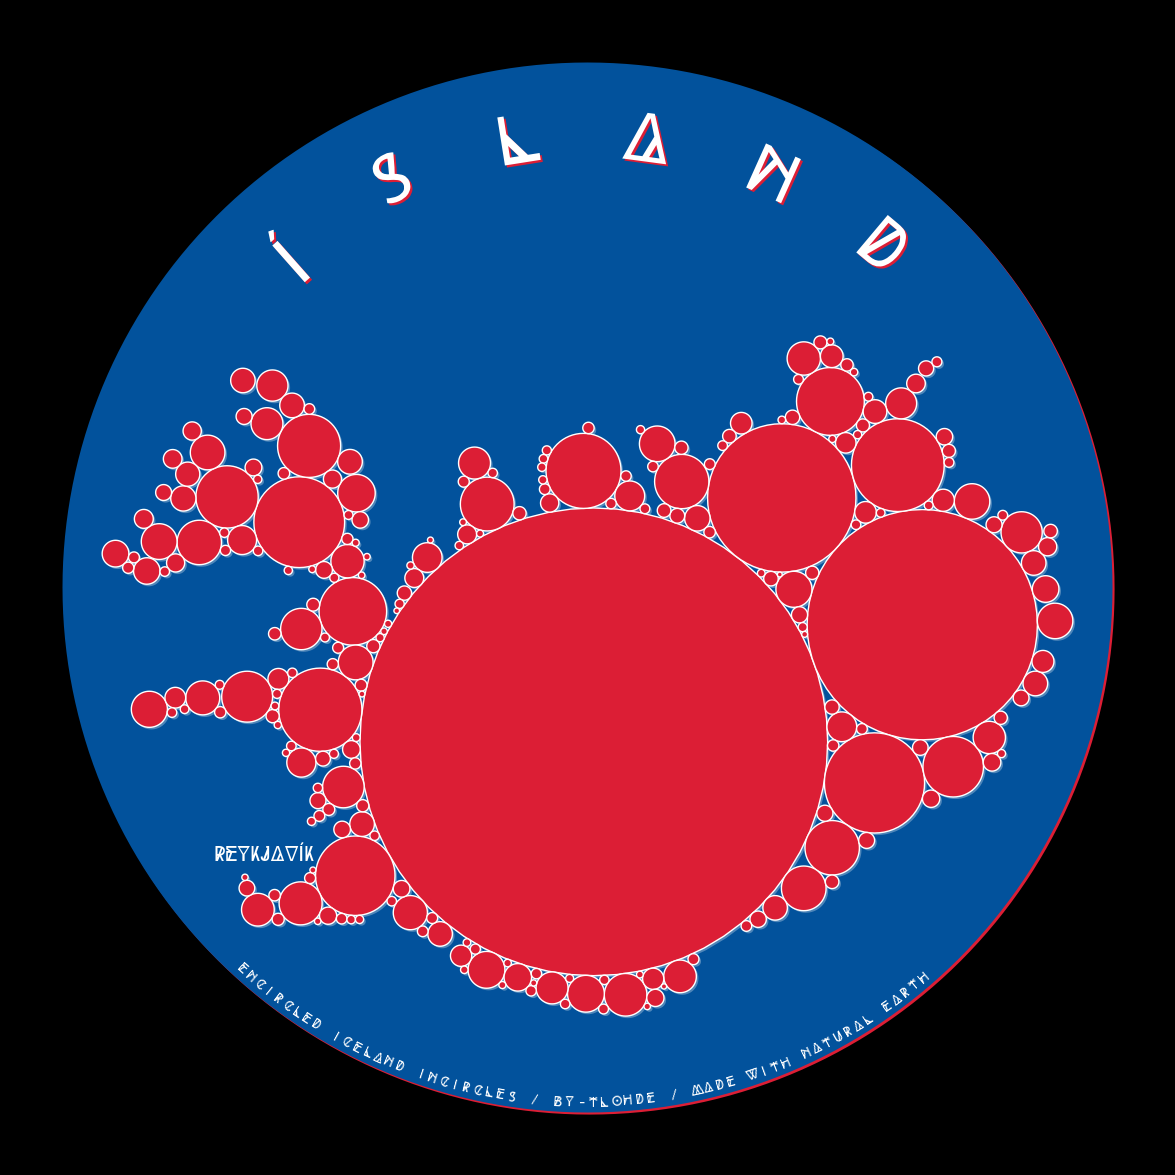

In [9]:
fig, ax = plt.subplots(figsize=[15,15])

# plot drop shadow patch on enclosing circle
ax.plot(*enclosing.exterior.coords.xy,
        path_effects=[path_effects.SimplePatchShadow(offset=(1.5,-1.5),
                                                     shadow_rgbFace='#DC1E35',
                                                     alpha=1)],
        zorder=0)

# plot enclosing circle
frame_gdf.plot(ax=ax,
               color='#02529C',
               zorder=0)

# all the circles
circle_gdf.plot(ax=ax,
                fc='#DC1E35',
                zorder=2,
                ec='w',)

# drop shadows on all the circles
_ = [ax.plot(*geom.exterior.coords.xy,
             path_effects=[path_effects.SimplePatchShadow(offset=(1.5, -1.5),
                                                          shadow_rgbFace='w')],
             zorder=1) for geom in circles.geoms]

# coordinate placement for title
xcoords, ycoords = enclosing.buffer(-24_000).exterior.coords.xy
top_idx = np.argmax(ycoords)
text_along_path('ÍSLAND',
                np.c_[xcoords[top_idx-30:top_idx+30],
                      ycoords[top_idx-30:top_idx+30]],
                ax,
                **{'ha':'center',
                   'va':'top',
                   'color':'w',
                   'path_effects':[path_effects.withSimplePatchShadow(offset=(1.5,-1.5),
                                                                      shadow_rgbFace='#DC1E35',
                                                                      alpha=1)],
                   'font_properties':{'family': 'High Tide',
                                      'size':50,
                                      }
                   }
                )

# add capital annotation
ax.annotate('Reykjavík',
            xy=(reykjavik[0].x, reykjavik[0].y),
            color='w',
            size=15,
            font='High Tide',
            ha='right',
            va='bottom')

# coordinate placement for credits
xcoords, ycoords = enclosing.buffer(-3_000).exterior.coords.xy
bottom_idx = np.argmin(ycoords)
text_along_path('encircled iceland incircles / by-tlohde / made with Natural Earth',
                np.c_[xcoords[bottom_idx+30:bottom_idx-30:-1],
                      ycoords[bottom_idx+30:bottom_idx-30:-1]],
                ax,
                **{'ha':'center',
                   'va':'bottom',
                   'color':'w',
                   'font_properties':{'family': 'High Tide',
                                      'size':10,
                                      }
                   }
                )



ax.set_axis_off()
fig.patch.set_color('k')

# fig.savefig('Ísland_circles_wCapital.png', dpi=300, bbox_inches='tight')

In [10]:
fig.savefig('iceland.pdf', dpi=300, bbox_inches='tight', pad_inches=0.2)

## stats

In [135]:
tot_area = iceland_geo.area
areas = [geom.area/tot_area for geom in circles.geoms]
exploded_gdf = gpd.GeoDataFrame({'area':areas}, geometry=list(circles.geoms), crs=utm_crs)
plt.plot(np.cumsum(areas))
plt.xlabel('number of circles')
plt.ylabel('fraction of area covered')
plt.savefig('cumulative_area_iceland.png')

## original thing - circles for all of europe

In [5]:
# circling all of europe - this takes a long time!!
aoi = shapely.Polygon([
    [25.88585454780423, 82.61557271258673],
    [0.9131153831379493, 80.9636526586342],
    [-4.830093579434418, 75.50509589726914],
    [-32.967335155198555, 62.80603934888859],
    [-15.727906081073314, 47.53800440707363],
    [-13.1454741403019, 35.75805848247872],
    [-6.3927892906386035, 35.91487399938042],
    [-5.871348513840928, 35.909692119824754],
    [-5.319515865716767, 35.984795927672394],
    [-5.078801034519046, 35.95842677818912],
    [-3.2314646408609917, 35.69823198665469],
    [-2.7492021889187015, 35.69490030421116],
    [0.23697268616345468, 37.32105793976622],
    [6.9859806782278895, 38.2158154135856],
    [11.268662645444465, 37.644233827746575],
    [11.519628761474337, 36.77236987315541],
    [11.628367843821962, 35.91993733224976],
    [12.155801022312204, 35.13022455734547],
    [16.008053797579578, 34.07190560463377],
    [28.864629442730546, 32.67848877333252],
    [29.729068023504198, 35.33047351717086],
    [28.121448734987695, 38.01595771537529],
    [30.429295760995075, 40.64533341230401],
    [36.61964054904175, 43.57814540561051],
    [37.14026773587307, 45.198537730340206],
    [38.77332251409453, 46.27191624286698],
    [41.68684471415369, 47.87262657144254],
    [39.56060113516267, 50.85779200152089],
    [33.49038604718922, 54.05329669206182],
    [31.634142571463002, 57.85874496648481],
    [46.234148680947044, 75.7776252907307],
    [25.88585454780423, 82.61557271258673]
    ])
europrj = ccrs.AlbersEqualArea(central_latitude=30, central_longitude=10, false_easting=0, false_northing=0, standard_parallels=(43,62))
europe = world.loc[(world.intersects(aoi)) & (world['admin']!='Russia')].clip(aoi)
europe = europe.to_crs(europrj)
europe = europe[['sovereignt', 'admin', 'geometry',
                 'mapcolor7', 'mapcolor8', 'mapcolor9', 'mapcolor13'
                 ]]
europe = europe.explode(index_parts=False).reset_index()
# europe.plot(column='admin', legend=False)
circles = {}
for row in tqdm(europe.itertuples()):
    multip = fill_with_circles(row.geometry,
                               target_ratio=0.925,
                               max_num=200,
                               Ngrid=21,
                               reps=20)
    circles[row.Index] = multip

europe['circles'] = circles.values()
europe = europe.set_geometry('circles')
europe.to_feather('europe_withCircles_925_200_31_20.feather')

In [ ]:
gdf = gpd.read_feather('europe_withCircles_925_200_31_20.feather')
europrj = ccrs.AlbersEqualArea(central_latitude=30, central_longitude=10, false_easting=0, false_northing=0, standard_parallels=(43,62))
gdf = gdf.set_crs(europrj)